In [1]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
import numpy as np
import pandas as pd

import copy
import traceback
import datetime
import joblib
import re
import os
import random
import string
import time
from collections import defaultdict

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchtext import data
from torchtext import vocab
from torchtext.vocab import Vectors, GloVe

from tqdm.notebook import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import pymorphy2
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
class ConfigExperiment:
    seed = 42
    positive_file = "../data/positive.csv"
    negative_file = "../data/negative.csv"
    russian_stop_words = "../data/russian_stop_words.txt"
    english_stop_words = "../data/english_stop_words.txt"
    test_size = 0.3
    device = "cuda" if torch.cuda.is_available() else "cpu"
    embed_dim = 100
    batch_size = 256
    num_epochs = 50
    lr = 1e-2
    num_workers = 0
    patience = 3
    early_stopping_delta = 1e-4
    save_dirname = "models"
    
config = ConfigExperiment()

In [4]:
def init_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic=True
    
init_random_seed(config.seed)

In [5]:
df = pd.read_csv("../data/preprocessed_text_v1.csv", index_col=False)
df.columns = ['text', 'target']

In [6]:
df.head()

,text,target
0,работа полный пиддес каждый закрытие месяц сви...,0
1,коллега сидеть рубиться urban terror долбать в...,0
2,говорят обещаной год ждать,0
3,желать хороший полёт удачный посадка быть очен...,0
4,обновить какой леший surf работать простоплеер,0


In [8]:
df['text'] = df['text'].map(str)

In [10]:
train_source, test_source = train_test_split(df, random_state=config.seed, test_size=config.test_size)
train_source.to_csv("../data/train_processed_data.csv", index=False)
test_source.to_csv("../data/test_processed_data.csv", index=False)

In [12]:
print('Количество обучающих текстов', len(train_source['text']))
print('Количество тестовых текстов', len(test_source['text']))

Количество обучающих текстов 158783
Количество тестовых текстов 68051


In [13]:
print(train_source['text'][0].strip())
print('Метка', train_source['target'][0])

работа полный пиддес каждый закрытие месяц свихнуться
Метка 0


In [25]:
train_tokenized = train_source['text'].tolist()
test_tokenized = test_source['text'].tolist()

In [26]:
train_tokenized[:10]

['luna самый самый любимый рождественский песенка год',
 'скачать симс лизин диск прийтись папка картинка поудалять пофига новый накачать',
 'появиться ощущение приближаться новое год ёлка радость поставить',
 'итак получить несколько зачёт неделя спасть усердно работать приболеть',
 'мозг кипеть спин разболеться',
 'хороший мотивация мысль стареть успеть',
 'равно мой солнышко просто разнообразие должный разный называть',
 'хороший учитель найти сложно мы ментор везти',
 'оказываться такой сладкое губа мммм forever alone',
 'дыы порнососа музыка слушать пытаться сам придумать фанфик']

In [35]:
set(train_tokenized[0].split())

{'luna', 'год', 'любимый', 'песенка', 'рождественский', 'самый'}

In [36]:
def build_vocabulary(tokenized_texts, max_size=1000000, max_doc_freq=0.8, min_count=5, pad_word=None):
    word_counts = defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt.split())
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq


In [38]:
MAX_DF = 0.8
MIN_COUNT = 5
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)

In [39]:
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 15123
[('хотеть', 0), ('весь', 1), ('день', 2), ('мочь', 3), ('такой', 4), ('сегодня', 5), ('очень', 6), ('быть', 7), ('мой', 8), ('просто', 9)]


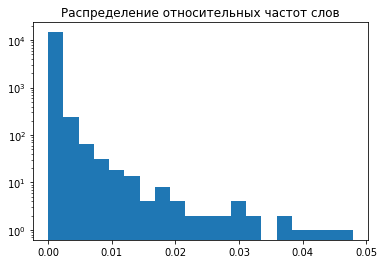

In [40]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [ ]:
def vectorize_texts(tokenized_texts, word2id, word2freq, scale=True):
    # считаем количество употреблений каждого слова в каждом документе
    result = scipy.sparse.dok_matrix((len(tokenized_texts), len(word2id)), dtype='float32')
    for text_i, text in enumerate(tokenized_texts):
        for token in text:
            if token in word2id:
                result[text_i, word2id[token]] += 1

    # учитываем всю информацию, которая у нас есть:
    # частоту слова в документе и частоту слова в корпусе
    result = result.tocsr()
    result = result.multiply(1 / result.sum(1))  # разделить каждую строку на её длину
    result = result.multiply(1 / word2freq)  # разделить каждый столбец на вес слова

    if scale:
        result = result.tocsc()
        result -= result.min()
        result /= (result.max() + 1e-6)

    return result.tocsr()

In [ ]:
VECTORIZATION_MODE = 'tfidf'
train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', train_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в обучающей выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

In [ ]:
def get_params_number(model):
    return sum(t.numel() for t in model.parameters())